# Building a PR Article Generation Application using Crew AI

This notebook demonstrates how to build a multi-agent system using [Langgraph](https://github.com/langchain-ai/langgraph) for automated PR article generation. The system uses a reflection pattern with multiple specialized agents that collaborate to write, review, and refine PR articles.

## Architecture Overview
- **PR Writer Agent**: Creates initial article drafts based on outlines
- **PR Reviewer Agent**: Reviews articles against quality guidelines
- **Supervisor Agent**: Orchestrates the workflow between agents

The following diagram depicts the overall architecture and the worklfow:

<img src="../../imgs/lab5-langgraph-architecture.png" width="800"> 


The system leverages AWS Bedrock for LLM capabilities and Knowledge Bases for retrieving examples of high-quality PR articles.






Retrieves the variables from previous notebooks for context.

In [1]:
%store -r

## AWS Service Setup

In the following cell, we initializes AWS clients needed for the notebook:

1. Creates an STS (Security Token Service) client to get the AWS account ID
2. Initializes a boto3 session to determine the current AWS region
3. Creates clients for Amazon S3 (for storage), Amazon Bedrock Runtime (for model inference), and Bedrock Agent Runtime
4. Imports ChatBedrockConverse from langchain_aws for interacting with Bedrock models


In [2]:
import boto3
from langchain_aws import ChatBedrockConverse
from typing import Optional

sts_client = boto3.client('sts')
session = boto3.session.Session()

account_id = sts_client.get_caller_identity()["Account"]
region = session.region_name

s3_client = boto3.client('s3', region)
bedrock_client = boto3.client('bedrock-runtime', region)
bedrock_agent_runtime_client = boto3.client("bedrock-agent-runtime", region)

## Langraph State Definition
At its core, LangGraph models agent workflows as graphs. The main component that allows communication between different nodes is done using State object.

[State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) is a shared data structure that represents the current snapshot of the agentic AI application. A state It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.

Working with our example, we create a state object to keep track of the generated article and review feedback. Later, we'll use a supervisor agent to orchestrate the PR article generation workflow. Each subagent (i.e. PR Revieewr, PR Writer) would perform it's corresponding task and emits updates to the State object to indicate the results. Using a State object improves consistency when information are being passed between the supervisor agent and the subagents. 

In particular, our State object consists of:

- `feedback`: To store review feedback on PR articles
- `article`: To store the PR article content
- `messages` To store the message history through the interaction (inherited)

In [3]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph
from langgraph.types import Command
from langchain_core.tools import tool, InjectedToolCallId
from typing import Annotated
from langgraph.graph import StateGraph, MessagesState, START
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.tools import tool

class CustomState(MessagesState):
    feedback: str
    article: str

# Define Knowledge Bases as a tool
In the following section, we define a function that will be served as a tool for our PR Writer. This tool provides the PR Writer with high quality examples of PR articles for specific genres. The PR Writer agent is configured to use this tool to get a reference of similar PR articles before writing a draft. 

In [4]:
from langchain_aws.retrievers import AmazonKnowledgeBasesRetriever

def invoke_kb(query: str, kb_id: str, region: str) -> str:
    """Invoke the knowledge base tool."""
    print("Retrieving from knowledge base...")
    bedrock_retriever = AmazonKnowledgeBasesRetriever(
        knowledge_base_id=lab5_kb_id,
        region_name = region,
        retrieval_config={"vectorSearchConfiguration": {"numberOfResults": 4}},
    )
    results = "\n".join([ x.page_content for x in bedrock_retriever.invoke(query) ])
    return results


## PR Writer Agent Setup
The following cell setups a PR Writer agent as followed:

1. Sets up the PR Writer agent by using a Bedrock foundation model (i.e. Amazon Nova Premier). 
2. Creates a detailed system prompt with guidelines for writing effective PR articles
3. Creates a ReAct agent using the LangGraph `create_react_agent` function with:
   - The specified LLM
   - The knowledge base tool
   - The detailed system prompt

In [12]:
from langchain_aws.retrievers import AmazonKnowledgeBasesRetriever
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

pr_writer_model_id = "us.anthropic.claude-3-5-haiku-20241022-v1:0"
pr_writer_llm = ChatBedrockConverse(
    model=pr_writer_model_id,
    temperature=0.3,
    max_tokens=None,
    client=bedrock_client,
)

pr_writer_system_prompt_template = f"""You are to write a PR article for an upcoming show/movie based on the user request, and an optional recommended changes.

When writing the PR article, you should follow the following guidelines:

1. Headline: Capture Attention & Key Details - Be Concise & Informative: Use active verbs like "announces," "debuts," or "unveils." Include the title, release date/platform, and a hook (e.g., talent or franchise ties).
Example: "A24 Reveals Trailer for Horror Thriller ‘Nightfall’ Starring Florence Pugh, Premiering October 2024."
Highlight Exclusives: If applicable, note premieres at festivals (e.g., "Sundance 2025 Official Selection").

2. Lead Paragraph: The 5 Ws - Summarize Who (studio, talent), What (title, genre), When (release date), Where (platforms/theaters), and Why (unique angle, legacy, or cultural relevance).
Example: "Marvel Studios’ ‘Avengers: Legacy,’ directed by Ryan Coogler, will premiere in theaters globally on May 3, 2025, marking the MCU’s first reboot of the iconic franchise."

3. Key Content Elements - Synopsis: Offer a 1–2 paragraph teaser without spoilers. Emphasize uniqueness (e.g., "a dystopian love story set in 2140’s AI-dominated society").
Talent & Production Credentials: Highlight A-list actors, acclaimed directors, or award-winning crews. Mention prior successes (e.g., "From the Oscar-winning producer of Parasite").
Behind-the-Scenes (BTS) Insights: Share filming locations, technical innovations, or adaptations (e.g., "Shot in Iceland using cutting-edge VR cinematography").

You also have access to a knowledge base tool that contains pristine, high quality PRs that have been published in the past. You should use the knowledge base in assisting with the writing.
The knowledge base ID you have acess to is {lab5_kb_id} and region is {region}.


Finally, the article content should be in markdown format. Put the entire article content in a <article> XML tag. Do not provide any other text other than the article. 
"""

pr_writer_agent = create_react_agent(
    model=pr_writer_llm,
    tools=[invoke_kb],
    prompt=pr_writer_system_prompt_template,
   name="pr_writer_agent"
)

### Define PR Write node
This cell defines the PR Writer node function that checks for any feedback exists in the state object (Populated by the PR Reviewer agent later), and perform the PR writing task. Notice the agent updates the state with the generated article. This step is to ensure the PR Reviewer has access to the PR article generated by this agent. 

In [13]:
def pr_writer(state: CustomState) -> Command:
    """PR writing tool that performs article writing.
    
    Args:
        state: The state dictionary
    """
    print("PR Writer....")
    if 'feedback' in state:
        print("Feedback found...")
        feedback = state["feedback"]
        feedback_prompt = f"""Here's the feedback from the reviewer:
---------
{feedback}        
---------
        """
        pr_writing_message = {"messages": [{"role": "user", "content": feedback_prompt}]}
        pr_writing_response = pr_writer_agent.invoke(pr_writing_message)
        return Command(update={
            "article": pr_writing_response["messages"][-1].content,
        })
    else:
        last_state_message = state["messages"][-1].content
        pr_writing_message = {"messages": [{"role": "user", "content": last_state_message}]}
        pr_writing_response = pr_writer_agent.invoke(pr_writing_message)
        return Command(update={ "article": pr_writing_response["messages"][-1].content})


Once the PR Writer agent is defined, we can start running some tests.
We provide a test query for the PR Writer agent that contains information about an outline of a fictional movie including the title, tagline, genre, release date, logline, and key production details.


In [8]:
pr_writer_test_query = """Write a PR news for an upcoming movie given the following outline: 
Title: Midnight Vendetta
Tagline: “When the clock strikes twelve, justice wears no mask.”
Genre: Action/Thriller
Release Date: November 22, 2025 (Theatrical & IMAX)

Logline:
A disgraced former MI6 agent infiltrates a glittering Dubai masquerade ball to dismantle a trillion-dollar cyberweapons syndicate—but must confront his deadliest enemy: the traitor who framed him for murder.

Key Production/Cast Details:
Director: David Leitch (Atomic Blonde, Bullet Train)—promises “brutally elegant fight choreography blending Bourne-style close combat with Dubai’s opulent settings.”
Studio: Pika Pictures (Budget: $200M)
Filming Locations: Dubai’s Burj Khalifa, Palm Jumeirah, and a custom-built 360-degree rotating ballroom set for the climactic fight.
Soundtrack: Pulse-pounding score by Ludwig Göransson 
"""

## Create Langgraph State Graph
In Langgraph, a State Graph is a graph whose nodes communicate by reading and writing to a shared state. We prepare the agent graph by defining the graph nodes and edges. Finally, we compile the state graph into an agent graph to make it ready to invoke. 

In [9]:
pr_writer_builder = StateGraph(CustomState)
pr_writer_builder.add_node("pr_writer", pr_writer)
# define the flow explicitly
pr_writer_builder.add_edge(START, "pr_writer")
pr_writer_agent_graph = pr_writer_builder.compile( name="pr_writer")


Invoke the PR Writing agent and printing the results

In [10]:
pr_writing_response = pr_writer_agent_graph.invoke({"messages": [{"role": "user", "content": pr_writer_test_query}]})
print(pr_writing_response)

PR Writer....
Retrieving from knowledge base...
{'messages': [HumanMessage(content='Write a PR news for an upcoming movie given the following outline: \nTitle: Midnight Vendetta\nTagline: “When the clock strikes twelve, justice wears no mask.”\nGenre: Action/Thriller\nRelease Date: November 22, 2025 (Theatrical & IMAX)\n\nLogline:\nA disgraced former MI6 agent infiltrates a glittering Dubai masquerade ball to dismantle a trillion-dollar cyberweapons syndicate—but must confront his deadliest enemy: the traitor who framed him for murder.\n\nKey Production/Cast Details:\nDirector: David Leitch (Atomic Blonde, Bullet Train)—promises “brutally elegant fight choreography blending Bourne-style close combat with Dubai’s opulent settings.”\nStudio: Pika Pictures (Budget: $200M)\nFilming Locations: Dubai’s Burj Khalifa, Palm Jumeirah, and a custom-built 360-degree rotating ballroom set for the climactic fight.\nSoundtrack: Pulse-pounding score by Ludwig Göransson \n', additional_kwargs={}, respo

Test with writing an article with review feedback, then prints the response to validate the output from the interaction.

In [11]:
test_feedback = """<feedback>
  - The press release is generally clear and engaging, but there are a few areas that could be improved for clarity and specificity.
  - The sentence "When a trillion-dollar cyberweapons syndicate threatens global security, only one man stands between chaos and order: Alex Kane, a former spy framed for murder." is a bit clunky and could be split into two sentences for better readability.
  - The phrase "a globe-trotting action thriller" could be more specific. Consider adding details about the locations or the type of action sequences.
  - The sentence "But as he navigates opulent ballrooms and high-stakes auctions, he discovers his deadliest enemy isn’t the cartel—it’s the ghost from his past who sold him out." could be simplified to avoid confusion.
  - The phrase "Bourne-style intimacy with Mission: Impossible spectacle" is quite technical and might not be clear to a non-technical audience. Consider explaining what this means in simpler terms.
  - The production budget of $200M is a good quantitative detail, but consider adding more specific information about the expected audience or box office expectations to give readers a clearer picture.
</feedback>"""
test_article = pr_writing_response["article"]
pr_writing_response = pr_writer_agent_graph.invoke({"messages": [{"role": "user", "content": "rewrite the article"}], "article" : test_article, "feedback": test_feedback})
print(pr_writing_response)

PR Writer....
Feedback found...
Retrieving from knowledge base...
{'messages': [HumanMessage(content='rewrite the article', additional_kwargs={}, response_metadata={}, id='0552abaa-a626-4e12-817b-4f1a91acf155')], 'feedback': '<feedback>\n  - The press release is generally clear and engaging, but there are a few areas that could be improved for clarity and specificity.\n  - The sentence "When a trillion-dollar cyberweapons syndicate threatens global security, only one man stands between chaos and order: Alex Kane, a former spy framed for murder." is a bit clunky and could be split into two sentences for better readability.\n  - The phrase "a globe-trotting action thriller" could be more specific. Consider adding details about the locations or the type of action sequences.\n  - The sentence "But as he navigates opulent ballrooms and high-stakes auctions, he discovers his deadliest enemy isn’t the cartel—it’s the ghost from his past who sold him out." could be simplified to avoid confusio

## PR Review Agent Setup
Similar to the PR Writer agent, we define a PR Review agent to perform review and provide feedback to improve the quality of the generated article. The agent is setup with:

1. A foundation model (Nova Pro) from Amazon Bedrock
2. Creates a system prompt with guidelines for reviewing PR articles, focusing on:
   - Clear and crisp sentences
   - Specificity
   - Writing for a non-technical audience

In [14]:
pr_review_agent_model_id = "us.amazon.nova-pro-v1:0"
pr_review_llm = ChatBedrockConverse(
    model=pr_review_agent_model_id,  # or another Claude model
    temperature=0.3,
    max_tokens=None,
    client=bedrock_client,
)
pr_reviewer_system_prompt = """You are an AI assistant that performs a review for a given PR article and provide any feedback to improve the quality. 
As a PR article reviewer, you are given the specific guidelines to evaluate the quality of the document.

1. Write in clear, crisp sentences." - long or confusing sentences as "clunky" when they're difficult for readers to understand.

Here are the tips on to identify unclear sentences:

- Sentences longer than 40 words or spanning more than two lines
- Sentences that require multiple readings to understand
- Sentences with repeated words, especially "and" and "to"

2. Be specific. Don't leave anything open to interpretation or leave your reader guessing. 

Here are some clues your sentence isn't specific enough: 
- it contains qualitative or subjective adjectives and adverbs (like "might," "often," or "may be"), 
- it leaves the reader asking questions.

Finally, provide your feedback in a <feedback> XML tag. Return only the feedback and nothing else.
"""

## PR Reviewer Node Function
In the following cell, we create a PR Reviewer node function that reads the state object for the article, and invoke a foundation model for review and feedback. Finally, the function returns a Command object with updates to the state with the feedback returned from the foundation model invocation.


In [15]:
def pr_reviewer(state: CustomState) -> Command:
    """PR review tool that performs review and provide feedback for the given article.
    
    Args:
        tool_call_id: the id of the tool
        state: The state dictionary
    """
    print("PR Reviewer....")
    print(f"custom state in PR Reviewer: {state}")
    if 'article' in state:
        print("Article found...")
        article = state["article"]
        messages = [ 
        ("system", pr_reviewer_system_prompt),
        ("human", f"""Review the given article: 
         
                  {article}

Return only the review feedback in <feedback> XML tag. Do not provide any other information.""")]
        response = pr_review_llm.invoke(messages)
        review_feedback = response.content
        
        return Command(update={
            "feedback": review_feedback,
        })


## Create Graph for PR Reviewer.
Similar to the PR Writer agent, we define PR Reviewer as a State graph by defining the graph nodes and edges. Finally, we compile the state graph into an agent graph to make it ready to invoke. 

In [16]:
pr_reviewer_builder = StateGraph(CustomState)
pr_reviewer_builder.add_node("pr_reviewer", pr_reviewer)
# define the flow explicitly
pr_reviewer_builder.add_edge(START, "pr_reviewer")
pr_reviewer_agent_graph = pr_reviewer_builder.compile( name="pr_reviewer")

Invokes the PR Reviewer graph with a synthetic article to review. The PR Reviewer analyzes the article and provides feedback.

In [17]:
pr_reviewer_agent_graph.invoke({"messages": [{"role": "user", "content": "review the given article"}], "article": pr_writing_response["article"]})

PR Reviewer....
custom state in PR Reviewer: {'messages': [HumanMessage(content='review the given article', additional_kwargs={}, response_metadata={}, id='f7483cd0-18f7-4d3e-936d-82ecc8ab5a67')], 'article': 'I\'ll revise the press release to address the specific feedback points, making it more clear, concise, and engaging:\n\n<article>\n# Universal Pictures Unveils High-Octane Spy Thriller \'Rogue Protocol\' Starring Chris Hemsworth\n\nUniversal Pictures has announced its upcoming global action thriller "Rogue Protocol," set to explode into theaters worldwide on September 15, 2024. Directed by Justin Lin and starring Chris Hemsworth, the film promises a pulse-pounding narrative of betrayal, redemption, and international intrigue.\n\n## A Spy\'s Last Stand\n\nAlex Kane\'s world is about to unravel. A former elite intelligence operative framed for a murder he didn\'t commit, Kane finds himself at the center of a dangerous global conspiracy. A trillion-dollar cyberweapons syndicate threa

{'messages': [HumanMessage(content='review the given article', additional_kwargs={}, response_metadata={}, id='f7483cd0-18f7-4d3e-936d-82ecc8ab5a67')],
 'feedback': '<feedback>\n- The sentence "A former elite intelligence operative framed for a murder he didn\'t commit, Kane finds himself at the center of a dangerous global conspiracy" is a bit clunky. Consider splitting it into two sentences for clarity: "A former elite intelligence operative framed for a murder he didn\'t commit, Kane finds himself at the center of a dangerous global conspiracy."\n- The phrase "A trillion-dollar cyberweapons syndicate threatens international security, and he\'s the only one who can stop them" could be more specific. Clarify what the syndicate is doing and how Kane plans to stop them.\n- The sentence "The film takes viewers on a breathtaking journey across multiple continents, from the neon-lit streets of Tokyo to the historic districts of Prague and the sun-baked landscapes of Dubai" is long. Conside

# Supervisor Agent Setup
In the following cell, we create a supervisor agent to manage the interactions between the PR Writer and PR Reviewer. The intent for the supervisor is to use reflection pattern to iteratively perform article writing and review feedback to improve the performance and accuracy of the PR article. Langgraph provides a prebuilt `supervisor agent` module. This is ideal for scenarios where no customizartion is required for the subagent. However, given we made modification to both the PR Writer and Reviwer agents, we'll create a supervisor step by step. The code is adapted from Langgraph supervisor example [here](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

In [20]:
from langgraph.prebuilt import InjectedState

def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        print(f"calling handoff to : {agent_name}")
        print(f"state: {state}")
        return Command(
            goto=agent_name,  
            update={**state, "messages": state["messages"] + [tool_message]},  
            graph=Command.PARENT,  
        )

    return handoff_tool


# Handoffs
assign_to_pr_writer_agent = create_handoff_tool(
    agent_name="pr_writer",
    description="Assign task to a pr_writer agent.",
)

assign_to_pr_reviewer_agent = create_handoff_tool(
    agent_name="pr_reviewer",
    description="Assign task to a pr_reviewer agent.",
)

supervisor_model_id = "us.anthropic.claude-3-5-haiku-20241022-v1:0"
# supervisor_model_id = "us.amazon.nova-premier-v1:0"

supervisor_llm = ChatBedrockConverse(
    model=supervisor_model_id,  # or another Claude model
    temperature=0.5,
    max_tokens=None,
    client=bedrock_client,
)

supervisor_agent = create_react_agent(
    model=supervisor_llm,
    tools=[assign_to_pr_writer_agent, assign_to_pr_reviewer_agent],
    prompt=f"""You are a supervisor AI agent. You are given the following subagents capable of following tasks:

1. pr_writer - Writes a PR article based on the given outline or rewrite a PR article based on the given feedback.

2. pr_reviewer - Reviews the PR article generated by the pr_writer to provide recommendation to improve the PR article.

You job is to delegate the writng and reviewing tasks to the given tools. Use these tool to write and review the article iteratively to arrive at the best version of the PR article. You should not make any changes to the articles.
Once you have completed the final review of the article, return the final article to the user.

Here are the guidelines:
- You must first write a draft article using the writing tool before performing any reviews. 
- You should only iterate the PR writing and review iterations for maximum of 1 time before returning the final version of the PR article to the user. 
The final draft of the PR must be a complete version formatted in markdown in the final response. Do not provide any explanation in the final response, return only the final PR article in markdown format.""",
    name="supervisor_agent"
)

## Create a Multi Agent Graph
Similar to the PR Writer and PR Reviewer agents, we used a StateGraph to define the graphs by adding each as a Node, and Edges to connect these agents: 

- The Supervisor agent with possible destinations to PR Writer, PR Reviewer, or END
- The PR Reviewer agent graph
- The PR Writer agent graph

Once the graph is compiled, it'll be ready to use. 
In the example, we also displays a visual representation of the graph to better understand the relationships between the nodes.


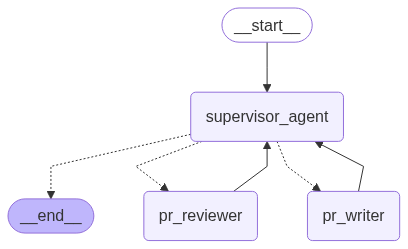

In [21]:
from langgraph.graph import END

builder = StateGraph(CustomState)
builder.add_node("supervisor_agent", supervisor_agent, destinations=("pr_writer", "pr_reviewer", END))
builder.add_node("pr_reviewer", pr_reviewer_agent_graph)
builder.add_node("pr_writer", pr_writer_agent_graph)

builder.add_edge(START, "supervisor_agent")
builder.add_edge("pr_writer", "supervisor_agent")
builder.add_edge("pr_reviewer", "supervisor_agent")
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Defines a test query for the supervisor agent.

In [22]:
query = """Write a PR article for an upcoming movie. Here's an outline: 

Title: Midnight Vendetta
Tagline: “When the clock strikes twelve, justice wears no mask.”
Genre: Action/Thriller
Release Date: November 22, 2025 (Theatrical & IMAX)

Logline:
A disgraced former MI6 agent infiltrates a glittering Dubai masquerade ball to dismantle a trillion-dollar cyberweapons syndicate—but must confront his deadliest enemy: the traitor who framed him for murder.

Key Production/Cast Details:
Director: David Leitch (Atomic Blonde, Bullet Train)—promises “brutally elegant fight choreography blending Bourne-style close combat with Dubai’s opulent settings.”
Studio: Pika Pictures (Budget: $200M)
Filming Locations: Dubai’s Burj Khalifa, Palm Jumeirah, and a custom-built 360-degree rotating ballroom set for the climactic fight.
Soundtrack: Pulse-pounding score by Ludwig Göransson 
"""

Invoke the supervisor agent graph with the test query and prints the final PR article generated by the system after multiple rounds of writing and reviewing

In [23]:
supervisor_agent_response = graph.invoke({"messages": [{"role": "user", "content": query}]})
print(supervisor_agent_response['messages'][-1].content)

calling handoff to : pr_writer
state: {'messages': [HumanMessage(content="Write a PR article for an upcoming movie. Here's an outline: \n\nTitle: Midnight Vendetta\nTagline: “When the clock strikes twelve, justice wears no mask.”\nGenre: Action/Thriller\nRelease Date: November 22, 2025 (Theatrical & IMAX)\n\nLogline:\nA disgraced former MI6 agent infiltrates a glittering Dubai masquerade ball to dismantle a trillion-dollar cyberweapons syndicate—but must confront his deadliest enemy: the traitor who framed him for murder.\n\nKey Production/Cast Details:\nDirector: David Leitch (Atomic Blonde, Bullet Train)—promises “brutally elegant fight choreography blending Bourne-style close combat with Dubai’s opulent settings.”\nStudio: Pika Pictures (Budget: $200M)\nFilming Locations: Dubai’s Burj Khalifa, Palm Jumeirah, and a custom-built 360-degree rotating ballroom set for the climactic fight.\nSoundtrack: Pulse-pounding score by Ludwig Göransson \n", additional_kwargs={}, response_metadata={

## Summary
This notebook demonstrates a multi-agent system built with Amazon Bedrock and LangGraph. The system consists of:

1. A PR Writer agent that generates PR articles based on provided information and can incorporate feedback
2. A PR Review agent that evaluates PR articles and provides detailed feedback
3. A Supervisor agent that orchestrates the collaboration between the Writer and Reviewer

The agents work together iteratively to produce a polished PR article, with each iteration improving the quality based on the reviewer's feedback. The system leverages a knowledge base of high-quality PR examples to guide the writing process.

Key technical components include:
- Custom state management with LangGraph's StateGraph
- Tool-using agents created with LangGraph's create_react_agent
- Agent handoff mechanisms for coordinating multiple specialized agents
- Knowledge base integration using Amazon Bedrock Knowledge Bases
- Structured feedback loops for iterative improvement

This pattern of agent collaboration can be applied to many other domains where specialized agents can work together to solve complex problems or create high-quality outputs.